In [91]:
import pandas as pd
import numpy as np
import datetime
import time
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from random import choices, sample
from gensim.models import Word2Vec
import gc
pd.set_option('display.float_format',lambda x : '%.2f' % x)
from math import log10

In [2]:
with open('./lt_df_Ali_8days.pkl', 'rb') as file:
    lt_df = pickle.load(file)

In [124]:
lt_df[0].columns

Index(['uid', 'hist_iid', 'hist_cid', 'target_iid', 'target_cid', 'next_iid',
       'next_cid', 'knn_rank', 'NN_rank', 'DIN_rank', 'DIEN_rank', 'label',
       'hist_len', 'train_label'],
      dtype='object')

In [3]:
lt_df[0]

,uid,hist_iid,hist_cid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank
0,7,"[980099, 3427154, 2689961, 2292610, 4034225, 5...","[2355072, 4801426, 4756105, 4756105, 3607361, ...",2063176,149192,1793668,2520377,53.0,40,95,45
1,96,"[3005381, 4160584]","[1464116, 3607361]",4160584,3607361,13283,3607361,5.0,7,15,94
2,152,"[842950, 3048082, 3682882]","[4145813, 4181361, 4181361]",3682882,4181361,3739757,4181361,6.0,6,45,18
3,239,"[709710, 4826455, 709710, 1992230, 1842641, 45...","[1787510, 1787510, 1787510, 2465336, 2976589, ...",5030834,1787510,24834,1787510,28.0,16,89,11
4,339,"[3437026, 3523692, 1850821, 1687195, 2487310, ...","[3738615, 2558244, 4756105, 4022701, 3738615, ...",222342,4244487,1692072,4244487,4.0,1,50,61
...,...,...,...,...,...,...,...,...,...,...,...
14738,1017455,"[3878908, 2029728, 4877816, 4736367, 1387695]","[982926, 149192, 4801426, 5042232, 4756105]",1387695,4756105,1584827,4756105,2.0,24,10,20
14739,1017559,"[969064, 7521, 1367959, 812391, 4257874]","[903809, 903809, 903809, 903809, 903809]",4257874,903809,2736720,903809,34.0,80,40,39
14740,1017591,"[777173, 2503250, 4551433]","[2885642, 2885642, 2885642]",4551433,2885642,2157244,2885642,38.0,91,3,51
14741,1017830,"[2382143, 964233, 310906, 4676590]","[4801426, 4801426, 4801426, 2096639]",4676590,2096639,2609472,2096639,97.0,67,51,30


In [4]:
def gen_label(df):
    if df.knn_rank <= df.NN_rank and  df.knn_rank <= df.DIN_rank and df.knn_rank <= df.DIEN_rank:
        label = 0
    elif df.NN_rank <= df.knn_rank and  df.NN_rank <= df.DIN_rank and df.NN_rank <= df.DIEN_rank:
        label = 1
    elif df.DIN_rank <= df.knn_rank and  df.DIN_rank <= df.NN_rank and df.DIN_rank <= df.DIEN_rank:
        label = 2
    elif df.DIEN_rank <= df.knn_rank and  df.DIEN_rank <= df.NN_rank and df.DIEN_rank <= df.DIN_rank:
        label = 3
    return label

In [5]:
for df in tqdm(lt_df):
    df['label'] = df.apply(gen_label, axis=1)

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [9]:
for df in tqdm(lt_df):
    df['hist_len'] = df.apply(lambda df: len(eval(str(df['hist_iid']))), axis=1)

100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


In [23]:
for df in tqdm(lt_df):
    df['train_label'] = df.apply(lambda df: to_categorical(df['label'], num_classes=4), axis=1)

100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


In [24]:
lt_df[0]

,uid,hist_iid,hist_cid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,train_label
0,7,"[980099, 3427154, 2689961, 2292610, 4034225, 5...","[2355072, 4801426, 4756105, 4756105, 3607361, ...",2063176,149192,1793668,2520377,53.0,40,95,45,1,16,"[0.0, 1.0, 0.0, 0.0]"
1,96,"[3005381, 4160584]","[1464116, 3607361]",4160584,3607361,13283,3607361,5.0,7,15,94,0,2,"[1.0, 0.0, 0.0, 0.0]"
2,152,"[842950, 3048082, 3682882]","[4145813, 4181361, 4181361]",3682882,4181361,3739757,4181361,6.0,6,45,18,0,3,"[1.0, 0.0, 0.0, 0.0]"
3,239,"[709710, 4826455, 709710, 1992230, 1842641, 45...","[1787510, 1787510, 1787510, 2465336, 2976589, ...",5030834,1787510,24834,1787510,28.0,16,89,11,3,66,"[0.0, 0.0, 0.0, 1.0]"
4,339,"[3437026, 3523692, 1850821, 1687195, 2487310, ...","[3738615, 2558244, 4756105, 4022701, 3738615, ...",222342,4244487,1692072,4244487,4.0,1,50,61,1,17,"[0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14738,1017455,"[3878908, 2029728, 4877816, 4736367, 1387695]","[982926, 149192, 4801426, 5042232, 4756105]",1387695,4756105,1584827,4756105,2.0,24,10,20,0,5,"[1.0, 0.0, 0.0, 0.0]"
14739,1017559,"[969064, 7521, 1367959, 812391, 4257874]","[903809, 903809, 903809, 903809, 903809]",4257874,903809,2736720,903809,34.0,80,40,39,0,5,"[1.0, 0.0, 0.0, 0.0]"
14740,1017591,"[777173, 2503250, 4551433]","[2885642, 2885642, 2885642]",4551433,2885642,2157244,2885642,38.0,91,3,51,2,3,"[0.0, 0.0, 1.0, 0.0]"
14741,1017830,"[2382143, 964233, 310906, 4676590]","[4801426, 4801426, 4801426, 2096639]",4676590,2096639,2609472,2096639,97.0,67,51,30,3,4,"[0.0, 0.0, 0.0, 1.0]"


In [11]:
lt_df[0]['label'].value_counts()

0    5864
1    4598
2    2188
3    2093
Name: label, dtype: int64

In [14]:
lt_df[0][lt_df[0]['label']==0].describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,5.864000e+03,5.864000e+03,5.864000e+03,5.864000e+03,5.864000e+03,5864.000000,5864.000000,5864.000000,5864.000000,5864.0,5864.000000
mean,5.046779e+05,2.562111e+06,2.697295e+06,2.551366e+06,2.664675e+06,10.034959,34.096180,52.805593,55.969475,0.0,14.622613
std,2.931972e+05,1.470190e+06,1.390165e+06,1.486192e+06,1.394918e+06,11.573257,26.689278,25.870459,26.954069,0.0,17.313889
min,9.600000e+01,1.369000e+03,5.060100e+04,1.197000e+03,5.064000e+03,1.000000,1.000000,5.000000,1.000000,0.0,1.000000
25%,2.536805e+05,1.276071e+06,1.567637e+06,1.253694e+06,1.464116e+06,2.000000,11.000000,32.000000,34.000000,0.0,3.000000
50%,5.015760e+05,2.585888e+06,2.465336e+06,2.557464e+06,2.465336e+06,5.000000,28.000000,52.000000,57.000000,0.0,9.000000
75%,7.553310e+05,3.835881e+06,3.776866e+06,3.853076e+06,3.749815e+06,14.000000,52.000000,74.000000,79.000000,0.0,19.000000
max,1.018006e+06,5.163006e+06,5.144469e+06,5.158324e+06,5.144469e+06,79.000000,99.000000,99.000000,99.000000,0.0,203.000000


In [15]:
lt_df[0][lt_df[0]['label']==1].describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,4.598000e+03,4.598000e+03,4.598000e+03,4.598000e+03,4.598000e+03,4598.000000,4598.000000,4598.000000,4598.000000,4598.0,4598.000000
mean,4.961904e+05,2.595916e+06,2.676617e+06,2.564050e+06,2.687782e+06,37.838191,11.795346,52.494780,56.096564,1.0,15.171379
std,2.946938e+05,1.467881e+06,1.402113e+06,1.462229e+06,1.389176e+06,26.857059,12.308065,27.180186,26.385931,0.0,18.695998
min,7.000000e+00,1.260000e+03,5.060100e+04,6.113000e+03,5.060100e+04,2.000000,1.000000,1.000000,1.000000,1.0,1.000000
25%,2.419788e+05,1.361860e+06,1.464116e+06,1.314588e+06,1.464116e+06,14.000000,3.000000,29.000000,35.000000,1.0,4.000000
50%,4.859030e+05,2.576232e+06,2.465336e+06,2.560262e+06,2.520377e+06,32.000000,7.000000,52.000000,58.000000,1.0,9.000000
75%,7.560660e+05,3.845720e+06,3.738615e+06,3.808246e+06,3.738615e+06,58.000000,16.000000,75.000000,79.000000,1.0,19.000000
max,1.017410e+06,5.158324e+06,5.063923e+06,5.162806e+06,5.071267e+06,99.000000,86.000000,99.000000,99.000000,1.0,235.000000


In [16]:
lt_df[0][lt_df[0]['label']==2].describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,2.188000e+03,2.188000e+03,2.188000e+03,2.188000e+03,2.188000e+03,2188.000000,2188.000000,2188.000000,2188.000000,2188.0,2188.000000
mean,5.123877e+05,2.575815e+06,2.706520e+06,2.665233e+06,2.805519e+06,50.368373,50.971207,16.968464,58.181444,2.0,15.158135
std,2.934962e+05,1.467457e+06,1.409950e+06,1.493430e+06,1.398795e+06,27.665527,26.457074,14.806337,25.226446,0.0,17.289346
min,7.230000e+02,3.501000e+03,9.874000e+03,7.640000e+02,5.060100e+04,6.000000,2.000000,1.000000,2.000000,2.0,1.000000
25%,2.617022e+05,1.318943e+06,1.464116e+06,1.403042e+06,1.787510e+06,27.000000,29.000000,5.000000,39.000000,2.0,4.000000
50%,5.102790e+05,2.582938e+06,2.465336e+06,2.657547e+06,2.735466e+06,49.000000,50.000000,13.000000,60.000000,2.0,9.000000
75%,7.713908e+05,3.810981e+06,4.145813e+06,3.981584e+06,4.145813e+06,74.000000,72.000000,25.000000,80.000000,2.0,20.000000
max,1.017591e+06,5.153870e+06,5.063923e+06,5.159258e+06,5.053508e+06,99.000000,99.000000,83.000000,99.000000,2.0,192.000000


In [17]:
lt_df[0][lt_df[0]['label']==3].describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2093.000000,2093.000000,2093.000000,2093.000000,2093.0,2093.000000
mean,5.024286e+05,2.583110e+06,2.658623e+06,2.560322e+06,2.702795e+06,48.459627,49.736742,56.259436,15.973244,3.0,15.825131
std,2.948903e+05,1.475279e+06,1.387663e+06,1.483773e+06,1.385084e+06,27.656420,27.526486,25.122778,14.633811,0.0,19.730304
min,2.390000e+02,1.465000e+03,5.060100e+04,1.197000e+03,2.410400e+04,2.000000,2.000000,2.000000,1.000000,3.0,1.000000
25%,2.501200e+05,1.320959e+06,1.464116e+06,1.266269e+06,1.521931e+06,24.000000,26.000000,36.000000,4.000000,3.0,4.000000
50%,5.003300e+05,2.567424e+06,2.465336e+06,2.555853e+06,2.520377e+06,48.000000,49.000000,57.000000,11.000000,3.0,9.000000
75%,7.506830e+05,3.853076e+06,3.702593e+06,3.845526e+06,3.738615e+06,71.000000,73.000000,78.000000,24.000000,3.0,20.000000
max,1.017830e+06,5.162674e+06,5.144469e+06,5.159307e+06,5.144469e+06,99.000000,99.000000,99.000000,77.000000,3.0,204.000000


---

In [25]:
full_table = pd.concat(lt_df[:4], ignore_index=True)

In [26]:
full_table.describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,5.416800e+04,5.416800e+04,5.416800e+04,5.416800e+04,5.416800e+04,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000
mean,5.017105e+05,2.587004e+06,2.692997e+06,2.574954e+06,2.687924e+06,29.960881,31.866674,47.949025,50.326134,1.031439,14.397116
std,2.945226e+05,1.471553e+06,1.390977e+06,1.470099e+06,1.392613e+06,28.082340,27.827058,28.027854,28.864340,1.056331,17.247801
min,5.000000e+00,3.240000e+02,9.874000e+03,8.100000e+01,5.064000e+03,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2.473645e+05,1.329654e+06,1.464116e+06,1.320040e+06,1.464116e+06,6.000000,8.000000,24.000000,25.000000,0.000000,3.000000
50%,4.963825e+05,2.596902e+06,2.520377e+06,2.566203e+06,2.465336e+06,20.000000,24.000000,46.000000,51.000000,1.000000,8.000000
75%,7.556350e+05,3.850265e+06,3.758209e+06,3.847054e+06,3.776866e+06,49.000000,51.000000,71.000000,75.000000,2.000000,19.000000
max,1.018011e+06,5.163006e+06,5.150761e+06,5.162806e+06,5.147460e+06,99.000000,99.000000,99.000000,99.000000,3.000000,269.000000


In [27]:
table_grby = full_table.groupby(['target_iid'])
pd.DataFrame(table_grby.size())

,0
target_iid,
324,1
764,1
1006,1
1197,1
1260,2
...,...
5162394,2
5162674,1
5162860,1


In [28]:
df_table  = pd.merge(full_table, pd.DataFrame(table_grby.size()), on=['target_iid'], how='left')
df_table.rename(columns = {0:'occur'}, inplace=True)

In [32]:
max_occur = max(df_table['occur'])

In [35]:
df_table['occur_log'] = df_table.apply(lambda df: log10(df['occur'])/log10(max_occur), axis=1)

In [36]:
df_table

,uid,hist_iid,hist_cid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,train_label,occur,occur_log
0,7,"[980099, 3427154, 2689961, 2292610, 4034225, 5...","[2355072, 4801426, 4756105, 4756105, 3607361, ...",2063176,149192,1793668,2520377,53.0,40,95.0,45,1,16,"[0.0, 1.0, 0.0, 0.0]",4,0.267243
1,96,"[3005381, 4160584]","[1464116, 3607361]",4160584,3607361,13283,3607361,5.0,7,15.0,94,0,2,"[1.0, 0.0, 0.0, 0.0]",1,0.000000
2,152,"[842950, 3048082, 3682882]","[4145813, 4181361, 4181361]",3682882,4181361,3739757,4181361,6.0,6,45.0,18,0,3,"[1.0, 0.0, 0.0, 0.0]",1,0.000000
3,239,"[709710, 4826455, 709710, 1992230, 1842641, 45...","[1787510, 1787510, 1787510, 2465336, 2976589, ...",5030834,1787510,24834,1787510,28.0,16,89.0,11,3,66,"[0.0, 0.0, 0.0, 1.0]",15,0.522045
4,339,"[3437026, 3523692, 1850821, 1687195, 2487310, ...","[3738615, 2558244, 4756105, 4022701, 3738615, ...",222342,4244487,1692072,4244487,4.0,1,50.0,61,1,17,"[0.0, 1.0, 0.0, 0.0]",28,0.642367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54163,1017568,"[2588261, 3012274, 3251448]","[4462359, 4462359, 4462359]",3251448,4462359,3916424,4462359,6.0,2,37.0,28,1,3,"[0.0, 1.0, 0.0, 0.0]",26,0.628081
54164,1017699,"[4093995, 4624511, 2501731, 10108, 2663450]","[1464116, 1464116, 4145813, 1464116, 1464116]",2663450,1464116,3941700,1464116,18.0,33,79.0,86,0,5,"[1.0, 0.0, 0.0, 0.0]",12,0.479029
54165,1017725,"[1586145, 2523726, 4974006, 1177678, 4505760, ...","[3002561, 3002561, 3002561, 3002561, 3002561, ...",2415077,2355072,3198981,2355072,22.0,11,19.0,70,1,42,"[0.0, 1.0, 0.0, 0.0]",1,0.000000
54166,1017744,"[1498368, 5104260, 2334734, 2926378, 1920864, ...","[846990, 982926, 2520377, 2520377, 2520377, 25...",2760413,2465336,3834207,2735466,8.0,19,24.0,97,0,23,"[1.0, 0.0, 0.0, 0.0]",7,0.375123


In [37]:
df_table.describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,occur,occur_log
count,5.416800e+04,5.416800e+04,5.416800e+04,5.416800e+04,5.416800e+04,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000,54168.000000
mean,5.017105e+05,2.587004e+06,2.692997e+06,2.574954e+06,2.687924e+06,29.960881,31.866674,47.949025,50.326134,1.031439,14.397116,15.094373,0.348373
std,2.945226e+05,1.471553e+06,1.390977e+06,1.470099e+06,1.392613e+06,28.082340,27.827058,28.027854,28.864340,1.056331,17.247801,26.111516,0.256182
min,5.000000e+00,3.240000e+02,9.874000e+03,8.100000e+01,5.064000e+03,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,2.473645e+05,1.329654e+06,1.464116e+06,1.320040e+06,1.464116e+06,6.000000,8.000000,24.000000,25.000000,0.000000,3.000000,2.000000,0.133622
50%,4.963825e+05,2.596902e+06,2.520377e+06,2.566203e+06,2.465336e+06,20.000000,24.000000,46.000000,51.000000,1.000000,8.000000,6.000000,0.345407
75%,7.556350e+05,3.850265e+06,3.758209e+06,3.847054e+06,3.776866e+06,49.000000,51.000000,71.000000,75.000000,2.000000,19.000000,16.000000,0.534487
max,1.018011e+06,5.163006e+06,5.150761e+06,5.162806e+06,5.147460e+06,99.000000,99.000000,99.000000,99.000000,3.000000,269.000000,179.000000,1.000000


In [38]:
df_table.groupby('occur').mean()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,occur_log
occur,,,,,,,,,,,,
1,500778.410021,2.605326e+06,2.777004e+06,2.582931e+06,2.777130e+06,38.600352,43.668461,47.817790,50.478618,1.223701,15.927879,0.000000
2,502924.039561,2.547849e+06,2.816028e+06,2.563383e+06,2.808790e+06,34.910738,38.657081,47.714594,50.399269,1.111868,15.635472,0.133622
3,498655.151989,2.501411e+06,2.778339e+06,2.573355e+06,2.805693e+06,32.358428,36.566761,49.155540,49.566288,1.066288,15.583570,0.211785
4,503076.348566,2.661772e+06,2.738330e+06,2.569775e+06,2.742394e+06,30.892473,33.020311,47.047790,50.757168,1.027180,14.952808,0.267243
5,500778.531818,2.676140e+06,2.782776e+06,2.551130e+06,2.790020e+06,31.435227,32.420076,48.535644,49.721970,1.060985,15.557576,0.310260
...,...,...,...,...,...,...,...,...,...,...,...,...
131,519820.129771,3.847054e+06,2.096639e+06,2.865862e+06,2.096639e+06,11.083969,16.900763,43.770992,52.763359,0.381679,9.076336,0.939818
158,492164.582278,1.773536e+06,2.096639e+06,2.073626e+06,2.096639e+06,24.563291,19.981013,58.892405,51.924051,0.955696,8.170886,0.975943
160,546039.131250,2.236861e+06,2.096639e+06,2.808003e+06,2.096639e+06,22.006250,15.981250,58.875000,48.931250,0.775000,8.968750,0.978368


---

In [42]:
model_w2v = Word2Vec.load("../Taobao_v3/iid_1days.model")

In [74]:
training_data = []
not_exist_id = []
Ground_Truth = []
for row in tqdm(df_table.iterrows()):
    if str(row[1]['target_iid']) not in model_w2v.wv:
        not_exist_id.append(row[1]['target_iid'])
        continue
    training_data.append(np.append(model_w2v.wv[str(row[1]['target_iid'])], [row[1]['occur_log']]))
    Ground_Truth.append(row[1]['train_label'])

54168it [00:06, 8546.10it/s]


In [75]:
training_data = np.array(training_data)

In [76]:
Ground_Truth = np.array(Ground_Truth)

In [77]:
training_data.shape

(54168, 129)

In [78]:
len(Ground_Truth)

54168

In [79]:
X_train, y_train = training_data, Ground_Truth

In [80]:
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, metrics, callbacks

In [81]:
model = models.Sequential()
model.add(layers.Dense(512, activation='linear', input_shape=(129,)))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(256, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(128, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(64, activation='linear'))
model.add(layers.LeakyReLU(alpha=0.3))
model.add(layers.Dense(4, activation='sigmoid'))

In [82]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.categorical_crossentropy,
             metrics=[metrics.categorical_accuracy])

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               66560     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [84]:
# checkpoint
filepath = './saved_model/' + 'Ali_switch' + '_' + time.strftime("%m%d", time.localtime()) + ".h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [85]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=.3,
                    verbose=1,
                    callbacks=callbacks_list)

Train on 37917 samples, validate on 16251 samples
Epoch 1/20
37917/37917 [==============================] - 1s 38us/step - loss: 1.2807 - categorical_accuracy: 0.4145 - val_loss: 1.2778 - val_categorical_accuracy: 0.4208

Epoch 00001: val_loss improved from inf to 1.27779, saving model to ./saved_model/Ali_switch_0509.h5
Epoch 2/20
37917/37917 [==============================] - 1s 35us/step - loss: 1.2682 - categorical_accuracy: 0.4267 - val_loss: 1.2736 - val_categorical_accuracy: 0.3991

Epoch 00002: val_loss improved from 1.27779 to 1.27356, saving model to ./saved_model/Ali_switch_0509.h5
Epoch 3/20
37917/37917 [==============================] - 1s 35us/step - loss: 1.2651 - categorical_accuracy: 0.4297 - val_loss: 1.2755 - val_categorical_accuracy: 0.4229

Epoch 00003: val_loss did not improve from 1.27356
Epoch 4/20
37917/37917 [==============================] - 1s 35us/step - loss: 1.2623 - categorical_accuracy: 0.4327 - val_loss: 1.2630 - val_categorical_accuracy: 0.4372

Epoch

In [86]:
history.history.keys()

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])

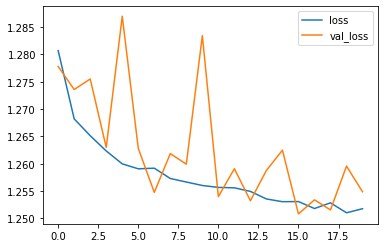

In [89]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

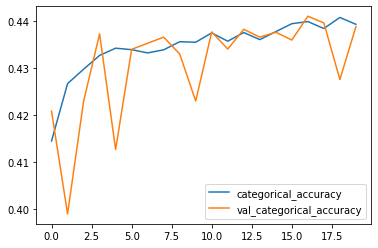

In [90]:
pd.DataFrame(history.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()

---

In [100]:
model = models.load_model('./saved_model/Ali_switch_0509.h5')

In [92]:
df_table_testday = pd.concat(lt_df[4:], ignore_index=True)

In [35]:
# df_table_testday.drop_duplicates(inplace=True, ignore_index=True)

In [94]:
df_table_testday.describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len
count,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00
mean,500967.22,2583610.90,2689736.19,2583089.62,2690628.35,30.08,32.00,47.66,50.02,1.05,14.56
std,293803.33,1475124.52,1398041.57,1469947.44,1396877.05,28.00,27.84,27.97,28.79,1.06,17.84
min,16.00,72.00,5064.00,608.00,5064.00,1.00,1.00,1.00,1.00,0.00,1.00
25%,247868.25,1320123.00,1464116.00,1341094.75,1464116.00,6.00,8.00,24.00,25.00,0.00,3.00
50%,494055.00,2598281.00,2520377.00,2587102.50,2520377.00,20.00,24.00,46.00,50.00,1.00,8.00
75%,756595.00,3849172.00,3747017.00,3853076.00,3775100.50,49.00,51.00,71.00,75.00,2.00,19.00
max,1017940.00,5162674.00,5150761.00,5163006.00,5144469.00,99.00,99.00,99.00,99.00,3.00,343.00


In [95]:
df_table_testday = pd.merge(df_table_testday, pd.DataFrame(table_grby.size()), on=['target_iid'], how='left')

In [96]:
df_table_testday.rename(columns = {0:'occur'}, inplace=True)

In [99]:
df_table_testday['occur'].fillna(1, inplace=True)

In [105]:
model.predict(np.append(model_w2v.wv['2063176'], 0.3).reshape(1, -1))[0]

array([0.78103715, 0.33529463, 0.21592233, 0.23367138], dtype=float32)

In [106]:
np.argmax(model.predict(np.append(model_w2v.wv['2063176'], 0.3).reshape(1, -1))[0])

0

In [107]:
sum(model.predict(np.append(model_w2v.wv['2063176'], 0.3).reshape(1, -1))[0])

1.565925493836403

In [116]:
def pred(df):
    if str(df['target_iid']) not in model_w2v.wv:
        return 0
    else:
        return np.argmax(model.predict(np.append(model_w2v.wv[str(df['target_iid'])], df['occur_log']).reshape(1, -1))[0])

In [110]:
def label_switch(df):
    label = df['pred']
    rank = None
    if label == 0:
        rank = df['knn_rank']
    elif label == 1:
        rank = df['NN_rank']
    elif label == 2:
        rank = df['DIN_rank']
    elif label == 3:
        rank = df['DIEN_rank']
    return rank

In [111]:
max_occur = max(df_table_testday['occur'])

In [112]:
df_table_testday['occur_log'] = df_table_testday.apply(lambda df: log10(df['occur'])/log10(max_occur), axis=1)

In [117]:
df_table_testday['pred'] = df_table_testday.apply(pred, axis=1)

In [118]:
df_table_testday['pred_rank'] = df_table_testday.apply(label_switch, axis=1)

In [120]:
df_table_testday.describe()

,uid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,occur,occur_log,pred,pred_rank
count,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00,57168.00
mean,500967.22,2583610.90,2689736.19,2583089.62,2690628.35,30.08,32.00,47.66,50.02,1.05,14.56,14.39,0.32,0.24,27.93
std,293803.33,1475124.52,1398041.57,1469947.44,1396877.05,28.00,27.84,27.97,28.79,1.06,17.84,25.61,0.27,0.43,27.09
min,16.00,72.00,5064.00,608.00,5064.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00
25%,247868.25,1320123.00,1464116.00,1341094.75,1464116.00,6.00,8.00,24.00,25.00,0.00,3.00,1.00,0.00,0.00,5.00
50%,494055.00,2598281.00,2520377.00,2587102.50,2520377.00,20.00,24.00,46.00,50.00,1.00,8.00,5.00,0.31,0.00,18.00
75%,756595.00,3849172.00,3747017.00,3853076.00,3775100.50,49.00,51.00,71.00,75.00,2.00,19.00,16.00,0.53,0.00,45.00
max,1017940.00,5162674.00,5150761.00,5163006.00,5144469.00,99.00,99.00,99.00,99.00,3.00,343.00,179.00,1.00,1.00,99.00


In [123]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(df_table_testday['label'].tolist(),df_table_testday['pred'].tolist()))

              precision    recall  f1-score   support

           0       0.43      0.83      0.57     22539
           1       0.45      0.35      0.40     17566
           2       0.00      0.00      0.00      8632
           3       0.00      0.00      0.00      8431

    accuracy                           0.44     57168
   macro avg       0.22      0.30      0.24     57168
weighted avg       0.31      0.44      0.35     57168



In [121]:
df_table_testday

,uid,hist_iid,hist_cid,target_iid,target_cid,next_iid,next_cid,knn_rank,NN_rank,DIN_rank,DIEN_rank,label,hist_len,train_label,occur,occur_log,pred,pred_rank
0,16,"[1068105, 2298434, 1993229, 440376, 2790322, 3...","[3248072, 3248072, 3248072, 4234389, 4234389, ...",1994146,3673501,3715112,883960,2.00,1,5.00,46,1,14,"[0.0, 1.0, 0.0, 0.0]",1.00,0.00,0,2.00
1,263,"[3133804, 5059894, 4749737]","[5046388, 2945933, 2096639]",4749737,2096639,3119053,2096639,73.00,36,54.00,11,3,3,"[0.0, 0.0, 0.0, 1.0]",12.00,0.48,1,36.00
2,358,"[3450505, 4750478, 2017785, 677155, 10108, 831...","[2739327, 2739327, 2739327, 4756105, 1464116, ...",4788857,2355072,5133563,2355072,20.00,96,64.00,31,0,7,"[1.0, 0.0, 0.0, 0.0]",1.00,0.00,0,20.00
3,480,"[1204358, 4817032, 1706966, 438788, 4255492, 1...","[2131531, 3607361, 2520771, 149192, 982926, 48...",524337,4801426,4320227,235534,94.00,3,48.00,75,1,7,"[0.0, 1.0, 0.0, 0.0]",1.00,0.00,0,94.00
4,490,"[4654918, 4698586, 1035871, 1677530, 947409, 4...","[245312, 5053508, 2131531, 2131531, 2131531, 9...",582970,1834026,3031863,1834026,1.00,4,46.00,16,0,27,"[1.0, 0.0, 0.0, 0.0]",21.00,0.59,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57163,1017814,"[11973, 3251377]","[883960, 2733371]",3251377,2733371,2944225,2733371,38.00,28,3.00,27,2,2,"[0.0, 0.0, 1.0, 0.0]",27.00,0.64,0,38.00
57164,1017891,"[1239068, 2584880]","[4145813, 1994940]",2584880,1994940,1980098,1994940,1.00,17,64.00,11,0,2,"[1.0, 0.0, 0.0, 0.0]",4.00,0.27,0,1.00
57165,1017898,"[2275478, 3811147, 2275478, 4852928]","[4758477, 4758477, 4758477, 4697972]",4852928,4697972,4632023,4697972,37.00,6,86.00,74,1,4,"[0.0, 1.0, 0.0, 0.0]",5.00,0.31,0,37.00
57166,1017934,"[4124393, 3303427]","[1859277, 570735]",3303427,570735,4847230,570735,21.00,23,64.00,34,0,2,"[1.0, 0.0, 0.0, 0.0]",17.00,0.55,1,23.00
